In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from scipy.ndimage import median_filter as medfilt

import sys
sys.path.insert(0, '../')

In [82]:
from libra import k296_all_transits, kepler296, transit_duration, transit_model

In [106]:
import kplr
client = kplr.API()

name = 'Kepler-296'
koi_number = 1422

# Find the target KOI.
koi = client.koi(koi_number + 0.01)

# Get a list of light curve datasets.
lcs = koi.get_light_curves(short_cadence=True)

# Loop over the datasets and read in the data.
time, flux, ferr, quality = [], [], [], []
for lc in lcs:
    with lc.open() as f:
        # The lightcurve data are in the first FITS HDU.
        hdu_data = f[1].data

        time.append(hdu_data["time"] + 2454833)
        flux.append(hdu_data["sap_flux"])
        ferr.append(hdu_data["sap_flux_err"])
        quality.append(hdu_data["sap_quality"])

for time_q, flux_q in zip(time, flux): 
    flux_q /= np.nanmedian(flux_q)
    not_nans = ~np.isnan(flux_q)
    p = np.polyfit(time_q[not_nans], flux_q[not_nans], 2)
    flux_q += 1 - np.polyval(p, time_q)

from scipy.ndimage import median_filter as medfilt
    
flux = np.concatenate(flux)#, (10,))
not_nans = ~np.isnan(flux)
time_i, flux_i = np.concatenate(time)[not_nans], flux[not_nans]/np.nanmedian(flux)
sort = np.argsort(time_i[~np.isnan(time_i) & ~np.isnan(flux_i)])
time = time_i[~np.isnan(time_i) & ~np.isnan(flux_i)][sort]
flux = flux_i[~np.isnan(time_i) & ~np.isnan(flux_i)][sort]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


In [107]:
# import sys
# sys.path.insert(0, '../../friedrich')
# from friedrich.lightcurve import LightCurve, concatenate_transit_light_curves

# lc = LightCurve(time, flux)

# planet_params = kepler296('b')
# planet_params.duration = transit_duration(planet_params)

# lightcurves = LightCurve(**lc.mask_out_of_transit(planet_params, oot_duration_fraction=2)).get_transit_light_curves(planet_params, )

# phased_times = []
# phased_fluxes = []
# for lc in lightcurves:
#     lc.fluxes /= np.median(lc.fluxes)
    
#     phased = (lc.times.jd - planet_params.t0) % planet_params.per
#     phased[phased > planet_params.per/2] -= planet_params.per
#     plt.scatter(phased, lc.fluxes, s=1)
    
#     phased_times.append(phased)
#     phased_fluxes.append(lc.fluxes)
# plt.show()

In [108]:
# from scipy.stats import binned_statistic

# bs = binned_statistic(np.concatenate(phased_times), np.concatenate(phased_fluxes), 
#                       statistic='median', bins=20)
# bincenters = 0.5*(bs.bin_edges[1:]+bs.bin_edges[:-1])
# plt.scatter(np.concatenate(phased_times), np.concatenate(phased_fluxes), s=1)

# model = transit_model(np.concatenate(phased_times)+planet_params.t0, planet_params)

# plt.scatter(np.concatenate(phased_times), model, marker='.', color='g')
# plt.scatter(bincenters, bs.statistic, marker='s', color='r', zorder=10)

# plt.ylim([0.994, 1.005])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:880: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd1 = apply_method(jd1)
/Users/bmmorris/anaconda/lib/python3.5/site-packages/astropy-3.0.dev19880-py3.5-macosx-10.6-x86_64.egg/astropy/time/core.py:881: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  jd2 = apply_method(jd2)
../../friedrich/friedrich/lightcurve.py:889: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  fluxes=self.fluxes[start_ind:end_ind],
../../friedrich/friedrich/lightcurve.py:890: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  errors=self.errors[start_ind:end_ind],
../../friedrich/friedrich/lightcurve.py:891: VisibleDeprecationWarning: co

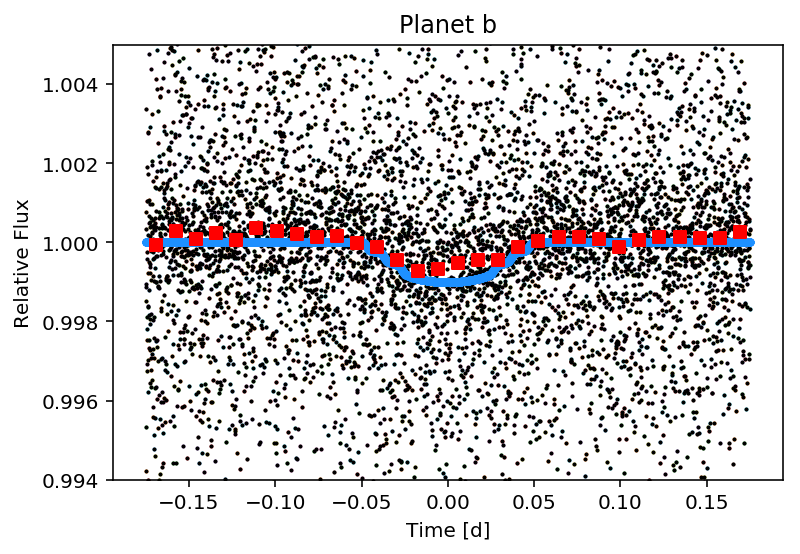

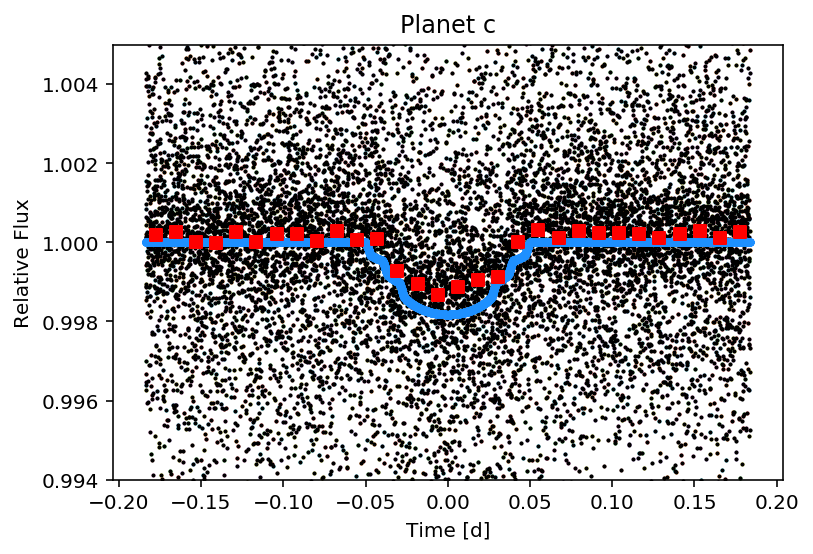

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/lib/polynomial.py:588: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


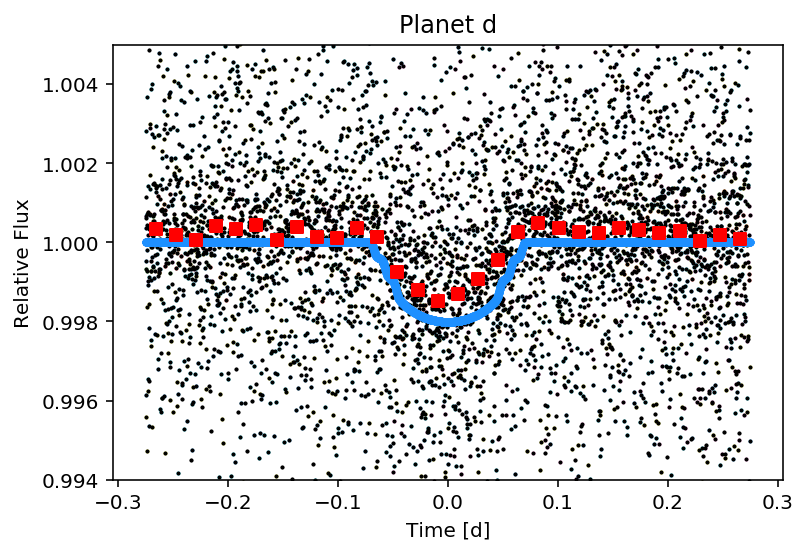

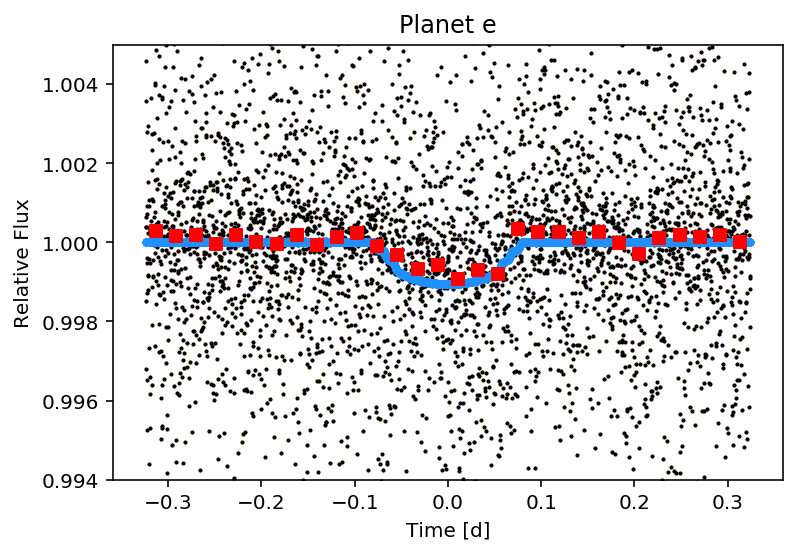

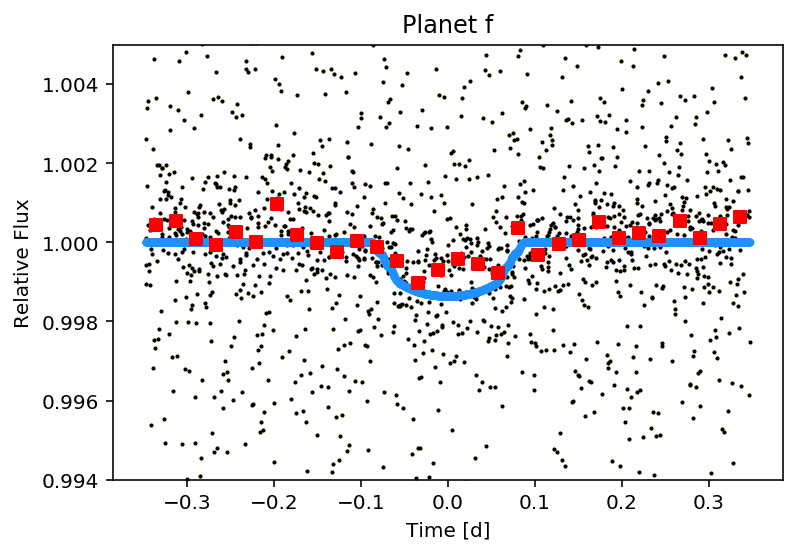

In [116]:
for planet in list('bcdef'):
    lc = LightCurve(time, flux)

    planet_params = kepler296(planet)
    planet_params.duration = transit_duration(planet_params)

    lightcurves = LightCurve(**lc.mask_out_of_transit(planet_params, oot_duration_fraction=2)).get_transit_light_curves(planet_params)

    phased_times = []
    phased_fluxes = []
    for lc in lightcurves:
        try: 
            p = np.polyfit(lc.times.jd - lc.times.jd.mean(), lc.fluxes, 1)
            fit = np.polyval(p, lc.times.jd - lc.times.jd.mean())
            lc.fluxes = lc.fluxes - fit + 1
        except ValueError: 
            lc.fluxes /= np.median(lc.fluxes)
        phased = (lc.times.jd - planet_params.t0) % planet_params.per
        phased[phased > planet_params.per/2] -= planet_params.per
        plt.scatter(phased, lc.fluxes, s=1)

        phased_times.append(phased)
        phased_fluxes.append(lc.fluxes)

    bs = binned_statistic(np.concatenate(phased_times), np.concatenate(phased_fluxes), 
                          statistic='median', bins=30)
    bincenters = 0.5*(bs.bin_edges[1:]+bs.bin_edges[:-1])
    plt.scatter(np.concatenate(phased_times), np.concatenate(phased_fluxes), s=1, color='k')

    model = transit_model(np.concatenate(phased_times)+planet_params.t0, planet_params)

    plt.scatter(np.concatenate(phased_times), model, marker='.', color='DodgerBlue')
    plt.scatter(bincenters, bs.statistic, marker='s', color='r', zorder=10)
    plt.title('Planet {}'.format(planet))
    plt.xlabel('Time [d]')
    plt.ylabel('Relative Flux')
    plt.ylim([0.994, 1.005])
    plt.show()